# Evaluation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# add parent package
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import from parent directory
from copac import COPAC, copac

from sklearn.datasets import make_classification

### Clustering of 2 feature space

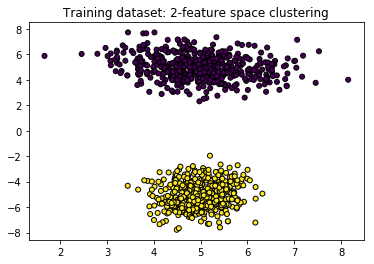

In [2]:
d = 2
n = 1000
difficulty = 5.0
X, y = make_classification(n_samples=n, n_features=d, n_redundant=0, n_informative=d,
                             n_clusters_per_class=1, class_sep=difficulty, random_state=4567)
# plot
plt.title("Training dataset: 2-feature space clustering")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.show()

## COPAC algorithm

To exetuce COPAC algorithm, we have to define following parameters:

- k : int, optional, default=10
        Size of local neighborhood for local correlation dimensionality.
        The paper suggests k >= 3 * n_features.
- mu : int, optional, default=5
        Minimum number of points in a cluster with mu <= k.
- eps : float, optional, default=0.5
        Neighborhood predicate, so that neighbors are closer than `eps`.

Below, the parameters for this evaluation are defined.

In [3]:
k = 6
mu = 10
eps = 2

### Our implementation of COPAC

Let's see how our implementation of COPAC algorithm will solve the introduced clustering problem.

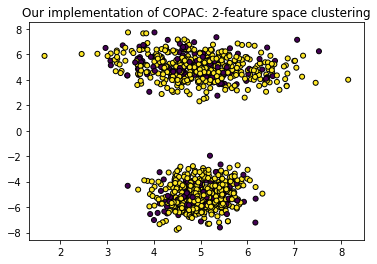

In [4]:
clst = COPAC(k=k, mu=mu, eps=eps, algorithm='auto')
y_pred = clst.fit_predict(X)
# plot
plt.title("Our implementation of COPAC: 2-feature space clustering")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y_pred, s=25, edgecolor='k')
plt.show()

### ELKI implementation of COPAC

First, we have to save the data into tsv file so that we prepare input for the ELKI package. Then start jar with correct parameters to execute and gather the output.

In [5]:
from subprocess import Popen, PIPE
import numpy as np

data_file_name = "data.tsv"

# write data into tsv file
np.savetxt(data_file_name, X, delimiter="\t")

# run elki
process = Popen(["java", "-cp", "elki-bundle-0.7.1.jar", "de.lmu.ifi.dbs.elki.application.KDDCLIApplication", 
                 "-dbc.in", "data.tsv",
                 "-algorithm", "clustering.correlation.COPAC",
                 "-copac.knn", str(k),
                 "-dbscan.epsilon", str(eps),
                 "-dbscan.minpts", str(mu)], 
                stdout=PIPE)
(output, err) = process.communicate()
exit_code = process.wait()

# remove data file
os.remove(data_file_name)

Now, we parse the input by regular expression and store it into a numpy array.

In [6]:
import re
a = output.decode("utf-8")
# initialize array of values and labels
Xelki = np.array([]).reshape(0,3)
# for each cluster, split by regex from output
for i, cluster in enumerate(a.split("Cluster: Cluster")[1:]):
    # find point coordinates in output
    values = re.findall(r"ID=\d+ ([-+]?\d+\.\d+) ([-+]?\d+\.\d+)", cluster)
    # create a numpy array of values
    Xpoints = np.array(values, dtype="d")
    # append label
    Xlabels = np.hstack((Xpoints, np.repeat(i, len(values)).reshape(-1,1)))
    # append to matrix
    Xelki = np.vstack((Xelki, Xlabels))
print(Xelki)

[[ 4.90516883 -6.58794319  0.        ]
 [ 4.69797892 -3.81858444  0.        ]
 [ 4.72596224  5.16501     0.        ]
 ..., 
 [ 4.83205094 -5.22053181  1.        ]
 [ 4.61547413 -4.28857489  1.        ]
 [ 4.75359521 -6.22968346  1.        ]]


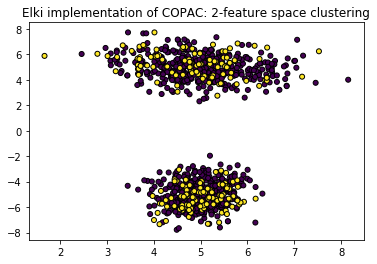

In [7]:
# plot
plt.title("Elki implementation of COPAC: 2-feature space clustering")
plt.scatter(Xelki[:, 0], Xelki[:, 1], marker='o', c=Xelki[:, 2], s=25, edgecolor='k')
plt.show()